# Social Networks Final Project: Protein-Protein Interactions (PPI)

**Group members:**

Marina Iuliana Aur, *1809715* <br>
Cristiana Di Tullio, *1803880*

## Import libraries and dependencies

In [ ]:
# Run if needed
%pip install torch-geometric
%pip install markov-clustering

In [2]:
# Import libraries
import pandas as pd
import numpy as np
import networkx as nx
from matplotlib import pyplot as plt
import plotly.express as px
import seaborn as sns
import itertools
import pprint
import torch
from torch.cuda import is_available
from torch_geometric.utils import to_networkx, negative_sampling
import markov_clustering as mc
from scipy.sparse import csr_matrix

In [3]:
# CPU/GPU
device = 'cpu'
if torch.cuda.is_available():
	device = 'gpu'

print(f'Using device {device}')

Using device cpu


## Utility functions

In [4]:
# Graph visualization functions from the SNOM Lab
# NOTE: the original input object was not a normal networkx graph
def convert_to_networkx(graph):
	g = to_networkx(graph, node_attrs = ['x'])
	y = graph.y.numpy()
	return g, y

def plot_graph(g, y):
	plt.figure(figsize = (9, 7))
	nx.draw_spring(g, node_size = 30, arrows = False, node_color = y)
	plt.show()

In [5]:
def print_dict(string, dictionary, n = 5):
    """
    Utility function to display only the first n elements
    of a dictionary.
    """
    dictionary = dict(dictionary)

    out = dict(itertools.islice(dictionary.items(), n))
    print(string)
    print("-" * len(string))
    pprint.pprint(out)
    print("")

## 1) Introduction


 ### 1.1) Dataset description

**(Da rivedere/sistemare/aggiungere)**  

We downloaded human protein-protein interaction (PPI) data from **BioGRID 4.4.236 CORONAVIRUS** [[¹]](https://downloads.thebiogrid.org/File/BioGRID/Release-Archive/BIOGRID-4.4.236/BIOGRID-CORONAVIRUS-4.4.236.tab3.zip) dataset. In response to the COVID-19 pandemic, intensive efforts by the international research community have generated a vast amount of new data on Severe Acute Respiratory Syndrome Coronavirus 2 (SARS-CoV-2), the causal agent of COVID-19. This includes data on related coronaviruses such as SARS-CoV and MERS-CoV, which cause Severe Acute Respiratory Syndrome (SARS) and Middle East Respiratory Syndrome (MERS), respectively.

Each row in the dataset represents a unique interaction between two proteins, allowing us to better understand the biology of the pathogen and facilitating the development of new therapeutic approaches. Specifically, the dataset includes information on all direct interactions between virally-encoded proteins and host cell proteins, as well as post-translational modifications and chemical interactions of viral proteins [[²]](https://thebiogrid.org/project/3/covid-19-coronavirus.html).


In [6]:
# Load PPI dataset
covid_df = pd.read_csv('BIOGRID-CORONAVIRUS-4.4.236.tab3.txt', sep = '\t')
covid_df.head()

,#BioGRID Interaction ID,Entrez Gene Interactor A,Entrez Gene Interactor B,BioGRID ID Interactor A,BioGRID ID Interactor B,Systematic Name Interactor A,Systematic Name Interactor B,Official Symbol Interactor A,Official Symbol Interactor B,Synonyms Interactor A,...,TREMBL Accessions Interactor B,REFSEQ Accessions Interactor B,Ontology Term IDs,Ontology Term Names,Ontology Term Categories,Ontology Term Qualifier IDs,Ontology Term Qualifier Names,Ontology Term Types,Organism Name Interactor A,Organism Name Interactor B
0,141211,850980,852501,31542,32899,YLR274W,YBR202W,MCM5,MCM7,BOB1|CDC46|MCM DNA helicase complex subunit MC...,...,-,NP_009761,-,-,-,-,-,-,Saccharomyces cerevisiae (S288c),Saccharomyces cerevisiae (S288c)
1,141212,852501,850980,32899,31542,YBR202W,YLR274W,MCM7,MCM5,CDC47|MCM DNA helicase complex subunit MCM7|L0...,...,-,NP_013376,-,-,-,-,-,-,Saccharomyces cerevisiae (S288c),Saccharomyces cerevisiae (S288c)
2,141213,850980,856680,31542,36697,YLR274W,YEL032W,MCM5,MCM3,BOB1|CDC46|MCM DNA helicase complex subunit MC...,...,-,NP_010882,-,-,-,-,-,-,Saccharomyces cerevisiae (S288c),Saccharomyces cerevisiae (S288c)
3,141214,856680,850980,36697,31542,YEL032W,YLR274W,MCM3,MCM5,MCM DNA helicase complex subunit MCM3|L000001039,...,-,NP_013376,-,-,-,-,-,-,Saccharomyces cerevisiae (S288c),Saccharomyces cerevisiae (S288c)
4,141215,852501,850793,32899,31376,YBR202W,YLR103C,MCM7,CDC45,CDC47|MCM DNA helicase complex subunit MCM7|L0...,...,-,NP_013204,-,-,-,-,-,-,Saccharomyces cerevisiae (S288c),Saccharomyces cerevisiae (S288c)


In [7]:
covid_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 60777 entries, 0 to 60776
Data columns (total 37 columns):
 #   Column                              Non-Null Count  Dtype 
---  ------                              --------------  ----- 
 0   #BioGRID Interaction ID             60777 non-null  int64 
 1   Entrez Gene Interactor A            60777 non-null  object
 2   Entrez Gene Interactor B            60777 non-null  object
 3   BioGRID ID Interactor A             60777 non-null  int64 
 4   BioGRID ID Interactor B             60777 non-null  int64 
 5   Systematic Name Interactor A        60777 non-null  object
 6   Systematic Name Interactor B        60777 non-null  object
 7   Official Symbol Interactor A        60777 non-null  object
 8   Official Symbol Interactor B        60777 non-null  object
 9   Synonyms Interactor A               60777 non-null  object
 10  Synonyms Interactor B               60777 non-null  object
 11  Experimental System                 60777 non-null  ob

In [8]:
# Maybe we can focus just on data relative to humans
# (covers 97% of original data anyway)
print('Original organisms in the dataset:\n')
print(pd.concat([covid_df['Organism Name Interactor A'], covid_df['Organism Name Interactor B']]).unique())
print('\n-----------------------\n')
print('After filtering by "Homo sapiens":\n')
# Select only rows whose Organism Interactor A or B is 'Homo sapiens'
human_df = covid_df[(covid_df['Organism Name Interactor A'] == 'Homo sapiens') | (covid_df['Organism Name Interactor B'] == 'Homo sapiens')]
human_df = human_df.reset_index(drop = True)
print(pd.concat([human_df['Organism Name Interactor A'], human_df['Organism Name Interactor B']]).unique())
print('\n-----------------------\n')
print('Datasets size ratio:', human_df.shape[0] / covid_df.shape[0])
print('New dataset dimension:', human_df.shape[0], 'observations')

Original organisms in the dataset:

['Saccharomyces cerevisiae (S288c)' 'Homo sapiens'
 'Severe acute respiratory syndrome coronavirus 2'
 'Severe acute respiratory syndrome-related coronavirus'
 'Cricetulus griseus'
 'Middle-East Respiratory Syndrome-related Coronavirus' 'Mus musculus'
 'Human Immunodeficiency Virus 1' 'Hepatitus C Virus' 'Bos taurus'
 'Equus caballus' 'Macaca mulatta' 'Sus scrofa' 'Danio rerio'
 'Rattus norvegicus' 'Escherichia coli (K12/MG1655)' 'Myotis lucifugus'
 'Canis familiaris' 'Chlorocebus sabaeus' 'Felis Catus'
 'Oryctolagus cuniculus' 'Schizosaccharomyces pombe (972h)'
 'Drosophila melanogaster' 'Gallus gallus' 'Plasmodium falciparum (3D7)']

-----------------------

After filtering by "Homo sapiens":

['Homo sapiens' 'Severe acute respiratory syndrome coronavirus 2'
 'Severe acute respiratory syndrome-related coronavirus'
 'Middle-East Respiratory Syndrome-related Coronavirus'
 'Human Immunodeficiency Virus 1' 'Hepatitus C Virus' 'Bos taurus'
 'Mus musculu

In [148]:
# Select PPI interactions
ppi = human_df[['Official Symbol Interactor A', 'Official Symbol Interactor B']]
ppi.head()

,Official Symbol Interactor A,Official Symbol Interactor B
0,CCND1,ESR1
1,BRCA1,ESR1
2,ESR1,BRCA1
3,ESR1,CCND1
4,CREBBP,IRF3


In [149]:
# Save the interactions for Gephi visualization
ppi = ppi.rename(columns={'Official Symbol Interactor A': 'Source', 'Official Symbol Interactor B': 'Target'})
ppi.to_csv('ppi_network.csv', index=False)

### 1.2) Network analysis

**(Da rivedere/sistemare/aggiungere)** In the PPI network, the concept of opinion dynamics can be linked to how changes in one protein can influence the behavior of other proteins. In a biological context, "opinion" can be viewed as the functional state of a protein. Opinion dynamics in a social network can be seen as analogous to how functional changes in central proteins can affect other proteins throughout the network.

In [209]:
# Check the shape of the dataframe without duplicates (it will not remove rows with the same genes but in different columns)
ppi = ppi.drop_duplicates()
print("Shape of the PPI network after removing duplicates:", ppi.shape)

Shape of the PPI network after removing duplicates: (43679, 2)


In [210]:
ppi_network = nx.from_pandas_edgelist(ppi,
                                      source = "Source",
                                      target = "Target",
                                      create_using = nx.Graph())      # nx.Graph() doesn't allow duplicated edges

print(ppi_network) #the nr of edges is lower than the nr of dataframe rows because of the non extracted duplicates

Graph with 8098 nodes and 43279 edges


In [211]:
# Identify self-loops
self_loops_bio = list(nx.selfloop_edges(ppi_network))
print("Number of self loops: ", len(self_loops_bio))
print("Self-loops over Total edges:", round(nx.number_of_selfloops(ppi_network) / len(ppi_network.edges), 4))

# Remove self-loops
ppi_network.remove_edges_from(self_loops_bio)
print("Graph without self-loops:", ppi_network)

Number of self loops:  52
Self-loops over Total edges: 0.0012
Graph without self-loops: Graph with 8098 nodes and 43227 edges


In [212]:
# Isolate the largest connected component (LCC)
components = list(nx.connected_components(ppi_network))
largest_component = max(components, key = len)
LCC_ppi = ppi_network.subgraph(largest_component)
print(LCC_ppi)

Graph with 8086 nodes and 43221 edges


In [213]:
# Compute metrics
degree = LCC_ppi.degree()
bet = nx.betweenness_centrality(LCC_ppi, k = 100, normalized = True) # richiede troppo tempo, per ora normalizzo con k=100
# clos = nx.closeness_centrality(LCC_ppi) -> richiede troppo tempo -> anche con la GPU?

In [157]:
try:
    eigen = nx.eigenvector_centrality(LCC_ppi, max_iter = 500, tol = 1e-04)
except nx.PowerIterationFailedConvergence as e:
    print(f"Failed to converge: {e}")

In [158]:
degree_dict = dict(degree)
ratio = {}

for node in LCC_ppi.nodes():
    if degree_dict[node] > 0:
        ratio[node] = bet[node] / degree_dict[node]
    else:
        ratio[node] = 0

In [159]:
# Insert metrics in the dictionary
nodes = LCC_ppi.nodes()
gene_measures = dict(nodes)

for gene in gene_measures:
    gene_measures[gene]["Degree"] = degree[gene]
    gene_measures[gene]["Betweeness"] = bet[gene]
    #gene_measures[gene]["Closeness"] = clos[gene]
    gene_measures[gene]["Eigen"] = eigen[gene]
    gene_measures[gene]["BetoverDeg"] = ratio[gene]
print_dict("Gene measures:", gene_measures)

Gene measures:
--------------
{'BRCA1': {'BetoverDeg': 1.8261912582317934e-06,
           'Betweeness': 3.6523825164635867e-06,
           'Degree': 2,
           'Eigen': 0.0007872599949043143},
 'CCND1': {'BetoverDeg': 6.375381280775041e-05,
           'Betweeness': 0.00031876906403875205,
           'Degree': 5,
           'Eigen': 0.001465708549714262},
 'CREBBP': {'BetoverDeg': 4.397533995184061e-06,
            'Betweeness': 2.6385203971104362e-05,
            'Degree': 6,
            'Eigen': 0.002317157076707439},
 'ESR1': {'BetoverDeg': 1.2956079989850904e-05,
          'Betweeness': 5.1824319959403614e-05,
          'Degree': 4,
          'Eigen': 0.001757955816001885},
 'IRF3': {'BetoverDeg': 2.447103805579034e-05,
          'Betweeness': 0.00036706557083685513,
          'Degree': 15,
          'Eigen': 0.0038324876180868303}}



In [161]:
# Build a metrics dataframe
measures_ppi = pd.DataFrame.from_dict(gene_measures, orient ='index')
measures_ppi = measures_ppi.reset_index()
measures_ppi.rename(columns={'index': 'Gene'}, inplace = True)

# Sort the output
sorted_metrics = measures_ppi.sort_values(by = 'Eigen', ascending = False)
sorted_metrics.reset_index(drop = True, inplace = True)
sorted_metrics['Ranking'] = sorted_metrics.index + 1
sorted_metrics.set_index('Ranking', inplace = True)

# Visualize the output
sorted_metrics.head()

,Gene,Degree,Betweeness,Eigen,BetoverDeg
Ranking,,,,,
1,M,2068,0.117782,0.239406,0.000057
2,ORF7b,1755,0.087955,0.213850,0.000050
3,nsp6,1684,0.057289,0.211439,0.000034
4,nsp4,1483,0.067650,0.203859,0.000046
5,ORF7a,1259,0.028882,0.178130,0.000023


 **(Da rivedere/sistemare/aggiungere)**

 **(Scrivere qualche considerazione di questo tipo)**

 From this table, we can make some statements about the nodes role in the disease network. We see that the nodes possessing a higher eigenvector centrality, namely M, ORF7b and nsp6 are all three proteins are encoded by viral genes, specifically from viruses such as coronaviruses. The M protein is crucial for virus assembly and budding, while ORF7b and nsp6 play roles in modulating host cell functions and immune responses.

 This suggests that in the context of Coronavirus disease, these nodes are likely to play significant regulatory roles in the network. In particular, M, which also has the highest degree, is likely to be a key regulatory node with substantial influence over other nodes.

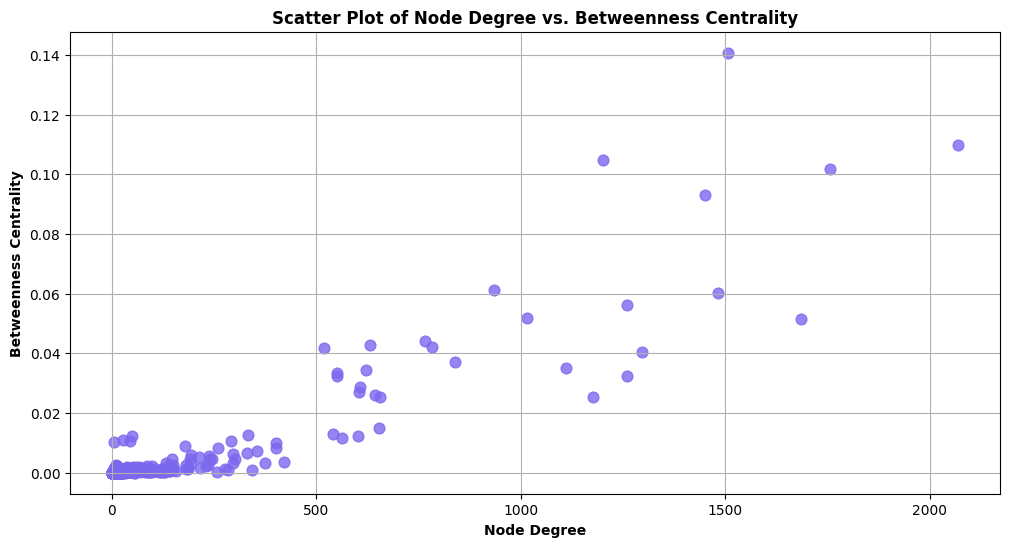

In [20]:
# Scatterplot of degree vs betweeness
x = measures_ppi['Degree']
y = measures_ppi['Betweeness']

plt.figure(figsize=(12, 6))
plt.scatter(x, y, color = 'mediumslateblue', alpha = 0.8, s = 60)

plt.title('Scatter Plot of Node Degree vs. Betweenness Centrality', fontweight='bold')
plt.xlabel('Node Degree', fontweight='bold')
plt.ylabel('Betweenness Centrality', fontweight='bold')
plt.grid()
plt.show()

In [21]:
# Average degree and degree distribution
print('\nAverage degree:', np.mean(sorted_metrics.Degree))
print('\n-----------------------')
fig = px.histogram(sorted_metrics.Degree,
                   nbins = len(sorted_metrics.Degree.unique()),
                   title = 'Degree distribution')
fig.update_layout(xaxis_title = 'degree', yaxis_title = 'count', bargap = 0.2)
fig.update_traces(marker_color = 'mediumslateblue')
fig.show()


Average degree: 10.69032896364086

-----------------------


**(Da rivedere/sistemare/aggiungere)**

The degree distribution in the PPI network follows a **scale-free model**: some proteins acts like *hubs* with very high number of interactions, while the majority of proteins interact with only a few others.

### 1.3) Network visualization

In [ ]:
# Plot the PPI Largest Connected Component -> troppo grande?
pos = nx.spring_layout(LCC_ppi, seed=42)

plt.clf()
plt.figure(figsize = (14, 10))
nx.draw(LCC_ppi, pos, with_labels = True, node_color = 'violet', node_size = 1000,
        edge_color = 'gray', linewidths = 1, font_size = 16)

plt.title("PPI Largest connected Component Network", fontweight = 'bold')
plt.show()

In [ ]:
# CAREFUL
# Takes a while to plot
plt.figure(figsize = (9, 7))
nx.draw_spring(LCC_ppi, node_size = 30, arrows = False, node_color = 'mediumslateblue')
plt.title('Protein-Protein Interaction Network')
plt.show()

${TO-DO:}$ it still takes too much to run. Try to run it in Colab with the GPU.

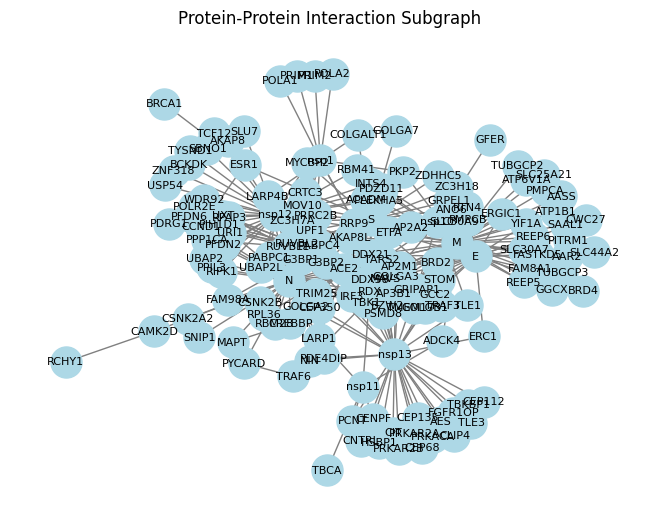

In [38]:
# Visualize only a subgraph of the network with fewer nodes for faster rendering
subgraph = LCC_ppi.subgraph(list(LCC_ppi.nodes)[:150])  # Take only a portion of the graph for visualization
pos = nx.spring_layout(subgraph, seed = 42)
nx.draw(subgraph, pos, with_labels = True, node_color ='lightblue', edge_color ='gray', node_size = 500, font_size = 8)

plt.title("Protein-Protein Interaction Subgraph")
plt.show()

## 2) Community detection

**(Da rivedere/sistemare/aggiungere)**

We experimented with clustering algorithms for community detection based on the **disease module hypothesis**. This hypothesis assumes that topological communities overlap with functional and disease modules and that the disease phenotype can be described by their breakdown.

In this context, we compared the outcomes of three algorithms that align with this assumption:

- **Kwik Cluster (or Pivot) Algorithm**
- **Markov Clustering (MCL) Algorithm**
- **Louvain Algorithm**

### Clustering Coefficient and Modularity

**(Da rivedere/sistemare/aggiungere)**

Proteins tend to form groups or modules, similar to how people in a social network form communities. Each module represents a set of related biological processes, as proteins involved in similar metabolic pathways are strongly interconnected.

In [36]:
clustering_coeff = nx.average_clustering(LCC_ppi)
print(f"PPI Network Clustering Coeffcient: {clustering_coeff}")

PPI Network Clustering Coeffcient: 0.05285528299003698


In protein-protein interaction (PPI) networks, it is common to observe relatively low global clustering coefficients. This is because protein interactions are often sparse, and not all proteins directly interact with each other.

### 2.1) KWIKCLUSTER (or PIVOT) Algorithm

### 2.2) Markov Cluster Algorithm

The Markov Clustering (MCL) algorithm detects clusters by simulating **random flow** through a graph.  It essentially performs matrix multiplication on the adjacency matrix of the graph to propagate the flow between nodes.

In [214]:
# Convert the LCC_ppi network to a suitable format for MCL algorithm
matrix = nx.to_scipy_sparse_array(LCC_ppi)
matrix = csr_matrix(matrix)
matrix.shape

(8086, 8086)


The **inflation parameter** controls the granularity of clustering:

- Inflation > 1: increases the tendency to form smaller and more distinct clusters, resulting in a greater number of clusters.
- Inflation < 1: increases the tendency to form larger and more general clusters, resulsing in fewer clusters as the algorithm becomes less aggressive in clustering.

In [245]:
# Run the MCL algorithm with inflaction = 1.8
result = mc.run_mcl(matrix, inflation = 1.8)
clusters = mc.get_clusters(result)

In [246]:
#select communities with a number of nodes between 100 and 1000
MCL_clusters_filtered = [cluster for cluster in clusters if 300 <= len(cluster) <= 1000]
print("Number of filtered MCL clusters: ", len(MCL_clusters_filtered))

Number of filtered MCL clusters:  5


In [247]:
for i, cluster in enumerate(MCL_clusters_filtered):
  print(f"Number of proteins in MCL Cluster {i + 1}: {len(cluster)}")

Number of proteins in MCL Cluster 1: 569
Number of proteins in MCL Cluster 2: 336
Number of proteins in MCL Cluster 3: 557
Number of proteins in MCL Cluster 4: 354
Number of proteins in MCL Cluster 5: 318


In [248]:
nodes = np.array(LCC_ppi.nodes())
MCL_clusters_filtered_2 = []
for cluster in MCL_clusters_filtered:
  cluster_names = [nodes[index] for index in cluster]
  MCL_clusters_filtered_2.append(cluster_names)

In [249]:
# positions = nx.spring_layout(LCC_ppi)
# mc.draw_graph(matrix, clusters, pos = positions, node_size = 50, with_labels = False, edge_color = "silver")

### 2.3) Louvain Algorithm

Louvain algorithm optimizes modularity by iteratively merging nodes into communities to maximize the **modularity score**.

The **resolution parameter** adjusts the scale of the communities detected:

- By increasing the sensitivity to modularity variations, the algorithm tends to identify smaller and more numerous communities.

- By decreasing the sensitivity to modularity variations, the algorithm tends to identify larger and fewer communities.

In [263]:
# Run the Louvain algorithm with gamma = 1.3
louvain_communities = nx.community.louvain_communities(LCC_ppi, weight = 'weight', resolution = 1, seed = 42)

In [264]:
#select communities with a number of nodes between 300 and 1000 ?
louvain_communities_filtered = [community for community in louvain_communities if 300 <= len(community) <= 1000]
print("Number of filtered Louvain communities: ", len(louvain_communities_filtered))

Number of filtered Louvain communities:  5


In [265]:
for i, community in enumerate(louvain_communities_filtered):
  print(f"Number of proteins in Louvain Community {i + 1}: {len(community)}")

Number of proteins in Louvain Community 1: 512
Number of proteins in Louvain Community 2: 460
Number of proteins in Louvain Community 3: 656
Number of proteins in Louvain Community 4: 523
Number of proteins in Louvain Community 5: 845


### Comparison

**Rendendo i clusters per entrambi i due algoritmi molto specifici, riusciamo ad ottenere una sovrapposizione più "elevata" tra i cluster formati dai due algoritmi. Rimane da capire se va bene così o provare altre opzioni**

In [267]:
set(MCL_clusters_filtered_2[0]).intersection(louvain_communities_filtered[0])

{'AES',
 'AGO3',
 'CCAR1',
 'CCDC6',
 'CDC42EP3',
 'CDC5L',
 'CDK5RAP2',
 'CGN',
 'CTR9',
 'DHX16',
 'EPS15L1',
 'EYA3',
 'FGFR1OP',
 'FN3KRP',
 'FRG1',
 'GABPA',
 'HGH1',
 'IRS2',
 'KLF16',
 'LPIN1',
 'LSM14A',
 'MAP2K4',
 'MED8',
 'METAP2',
 'MRRF',
 'MVB12A',
 'NOL7',
 'NSFL1C',
 'NSRP1',
 'PDE4DIP',
 'PRPF4B',
 'PSRC1',
 'SRSF11',
 'THOC2',
 'THOC3',
 'TLE1',
 'WIPF2'}

In [293]:
print(len(set(MCL_clusters_filtered_2[4]).intersection(louvain_communities_filtered[1])))
print(len(set(MCL_clusters_filtered_2[2]).intersection(louvain_communities_filtered[2])))
print(len(set(MCL_clusters_filtered_2[1]).intersection(louvain_communities_filtered[3])))
print(len(set(MCL_clusters_filtered_2[3]).intersection(louvain_communities_filtered[4])))

12
338
192
12


## 3) Link Prediction with Graph Neural Networks (GNNs)

 ### 3.1) Exploring different models to perform the prediction task

 GAT, GCN, etc.

 Transformers?

### 3.2) Evaluation of results

(using metrics such as confusion matrix, accuracy, precision, recall, F1 score, hits@k, etc.)

## [Optional: Influence and Homophily?]

For any experiment in this area, we can take into consideration the Organism Interactor name as the "class" to which the proteins belong. Remember that in this dataset every row represent an interaction between two proteins, and we have both names of their organisms. We might need to build a new graph containing this information (the one we use for community detection just contains the protein names).

## 4) Conclusions